# Cleaning East River Stem Geolocation Shapefiles
**Author:** 'Marshall Worsham' <br>
**Creation Date:** '09/21/2020' <br>
**Revision Date:** '12/22/2020' <br>

---

## Table of Contents

1 - [Front matter](#front)<br>
2 - [Import stem geolocation shapefiles](#import)<br>

---

## Front matter<a id='front'></a>

This notebook contains markdown and code for post-processing point shapefiles generated from Trimble Geo7X GPS acquisitions in the East River domain. The input is a set of shapefiles containing tree geolocation points, one set for each site in the watershed where stem geolocations were acquired from 2018–2020.

The script appends the `Site` name and `subdirectory` to each shapefile name, then selects all projected point shapefiles, groups them by `Site` name, and merges points from the same site. It then filters out undesired points (e.g., plot corners and plot edges)

The script was developed in `Python 3.8.2` on a Macbook Pro 2014 running OSX 10.14.6.


### Libraries<a id='libraries'></a>

In [8]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import re
from matplotlib import pyplot as plt
from os.path import join, getsize
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

### Define the working directories and list contents

In [10]:
directory = os.sep.join(['/Volumes', 'GoogleDrive', 'My Drive', 'Research', 'RMBL', 'Working_Files', 'Forest_Inventory_Dataset'])
source_dir = os.sep.join([directory, 'Source'])
scratch_dir = os.sep.join([directory, 'Scratch'])
out_dir = os.sep.join([directory, 'Output'])
stem_dir = os.sep.join([scratch_dir, 'GPS_Data_2021_MERGEDBYPLOT'])
os.listdir(stem_dir)

['XX-PLN1.shp',
 'XX-PLN1.shx',
 'XX-PLN1.dbf',
 'XX-PLN1.cpg',
 'XX-PLN1.prj',
 'SG-NES2.shp',
 'SG-NES2.shx',
 'SG-NES2.dbf',
 'SG-NES2.cpg',
 'SG-NES2.prj',
 'CC-CVS1.shp',
 'CC-CVS1.shx',
 'CC-CVS1.dbf',
 'CC-CVS1.cpg',
 'CC-CVS1.prj',
 'XX-PLN2.shp',
 'XX-PLN2.shx',
 'XX-PLN2.dbf',
 'XX-PLN2.cpg',
 'XX-PLN2.prj',
 'SR-PVG1.shp',
 'SR-PVG1.shx',
 'SR-PVG1.dbf',
 'SR-PVG1.cpg',
 'SR-PVG1.prj',
 'SG-NES3.shp',
 'SG-NES3.shx',
 'SG-NES3.dbf',
 'SG-NES3.cpg',
 'SG-NES3.prj',
 'ER-GT1.shp',
 'ER-GT1.shx',
 'ER-GT1.dbf',
 'ER-GT1.cpg',
 'ER-GT1.prj',
 'CC-UC1.shp',
 'CC-UC1.shx',
 'CC-UC1.dbf',
 'CC-UC1.cpg',
 'CC-UC1.prj',
 'XX-CAR3.shp',
 'XX-CAR3.shx',
 'XX-CAR3.dbf',
 'XX-CAR3.cpg',
 'XX-CAR3.prj',
 'SG-NES1.shp',
 'SG-NES1.shx',
 'SG-NES1.dbf',
 'SG-NES1.cpg',
 'SG-NES1.prj',
 'CC-CVN2.shp',
 'CC-CVN2.shx',
 'CC-CVN2.dbf',
 'CC-CVN2.cpg',
 'CC-CVN2.prj',
 'XX-CAR1.shp',
 'XX-CAR1.shx',
 'XX-CAR1.dbf',
 'XX-CAR1.cpg',
 'XX-CAR1.prj',
 'CC-CVN1.shp',
 'CC-CVN1.shx',
 'CC-CVN1.dbf',
 '

### Set pandas view to max rows and columns

In [11]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Import stem geolocation shapefiles<a id='import'></a>


In [284]:
# import the temp geodataframes from the append operations
stem_files = os.listdir(stem_dir)
stem_sf = [s for s in stem_files if s.endswith('.shp')]
stem_paths = [stem_dir + s for s in stem_sf]
appd_gpdf = []
for sf in stem_sf:
    gpdf = gpd.read_file(os.sep.join([stem_dir, sf]))
    appd_gpdf.append(gpdf)

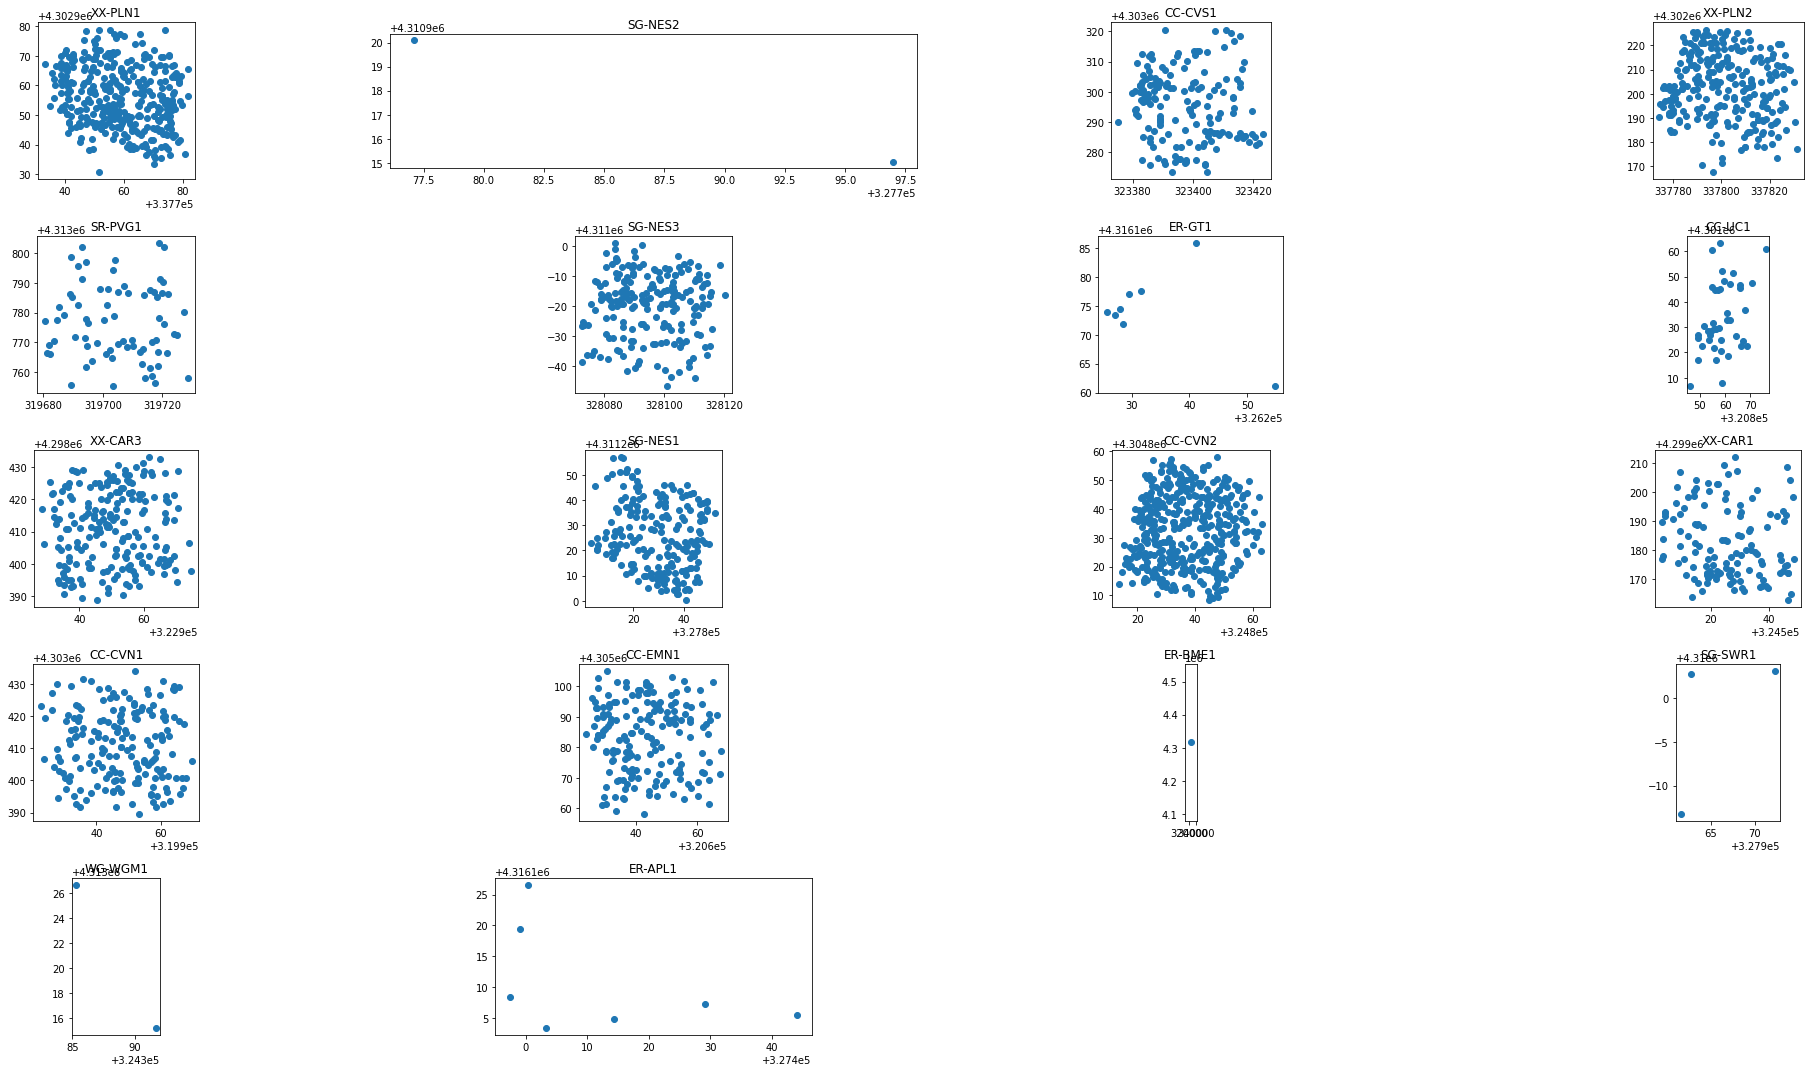

In [15]:
# Set a figure frame
plt.figure(figsize = (30,15))

# Plot the dataframes in sequence on the figure frame
for i, gpdf in enumerate(appd_gpdf):
    
    # create subplot axes in a 5x3 grid
    ax = plt.subplot(5, 4, i + 1) # nrows, ncols, axes position
    
    # set title
    ax.set_title(gpdf.Site[0])
    
    # plot the plot on these axes
    gpdf.plot(ax=ax)

plt.tight_layout();

## Some functions to interact

In [76]:
# print ordered list of new geodataframes
print([i for i in stem_files if i.endswith('.shp')])

['XX-PLN1.shp', 'SG-NES2.shp', 'CC-CVS1.shp', 'XX-PLN2.shp', 'SR-PVG1.shp', 'SG-NES3.shp', 'ER-GT1.shp', 'CC-UC1.shp', 'XX-CAR3.shp', 'SG-NES1.shp', 'CC-CVN2.shp', 'XX-CAR1.shp', 'CC-CVN1.shp', 'CC-EMN1.shp', 'ER-BME1.shp', 'SG-SWR1.shp', 'WG-WGM1.shp', 'ER-APL1.shp']


In [ ]:
# # function to interact with dataframe
# def fh_interact(df):
#     '''
#     outputs sliders that show rows and cols of df
#     '''
#     def peek(row = 1, col = 0):
#         return df.iloc[row: row+10, col: col+10]
#     interact(peek, row = (0, len(df), 5), col = (0, len(df.columns) - 6))
#     print('({} rows, {} columns total'.format(df.shape[0], df.shape[1]))

## Define a function to generate new points based on geotag association notes in field notebooks and GPS units
For some trees that were growing very closely together, we did not geotag each tree individually with the GPS unit in order to save battery and complete the inventory. Instead, we left directional notes in the `Other` or `Other2` field. These comments had the format, e.g. "6030 0.4m NW". This indicated that for a given geotagged tree, #6030 was an ungeotagged associated tree standing 0.4m to the northwest of the geotagged tree. We define a function below that uses those notes to construct geolocation points for the trees that were associated through these notes.

In [227]:
def makenewpoint(associationdf, reftag, targtag, direction, distance):
    '''
    Creates new point geometries for stems that weren't geotagged but have directional and distance references in notes. 
    Inputs:
        - gpdf: geodataframe storing geometry and association data
        - reftag: an integer indicating the reference (geotagged) tree tag number
        - targtag: an integer indicating the target (untagged associated) tree tag number
        - dir: string indicating cardinal direction from reference to target (e,n,w,s,ne,nw,sw,se) noted in 'Other' or 'Other2' field
        - distance: float indicating distance from reference to target noted in 'Other' or 'Other2' field
    Returns:
        - geopandas entry with point geometry
    '''

    # Conversion from degrees to radians
    rad = np.pi/180

    # Calculate cardinal directions as radian angles from east-facing origin
    erad = rad*0
    nrad = rad*90
    wrad = rad*180
    srad = rad*270
    nerad = rad*45
    nwrad = rad*135
    swrad = rad*225
    serad = rad*315

    # Define radian direction based on cardinal direction input
    if not isinstance(direction, float):
        if direction.lower() == 'e':
            raddir = erad
        elif direction.lower() == 'n':
            raddir = nrad
        elif direction.lower() == 'w':
            raddir = wrad
        elif direction.lower() == 's':
            raddir = srad
        elif direction.lower() == 'ne':
            raddir = nerad
        elif direction.lower() == 'nw':
            raddir = nwrad
        elif direction.lower() == 'sw':
            raddir = swrad
        elif direction.lower() == 'se':
            raddir = serad
    # elif isinstance(direction, float):
    else:
        intrad = rad*direction
        raddir = intrad

    # Find x,y coordinates of reference tag number
    refcoords = associationdf[associationdf['Tag_Number'] == reftag].geometry
    x = refcoords.x
    y = refcoords.y

    # Calculate coordinates of target tag number
    x_prime = distance * np.cos(raddir) + x
    y_prime = distance * np.sin(raddir) + y
    
    # print(targtag, raddir, x, y, x_prime, y_prime, sep='\n')

    # Create a new temp gpdf from new geometries   
    new_gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x_prime, y_prime, crs = 'epsg:32612'))
    new_gdf['Tag_Number'] = targtag
    new_gdf['Comment'] = 'Point generated post-campaign from geotag association note'
    new_gdf['Geotag_Association'] = reftag
    new_gdf = new_gdf[['Tag_Number', 'Comment', 'Geotag_Association', 'geometry']]

    return new_gdf

---
## Cleaning function


In [228]:
def cleansf(geodf, invsheet_id):
    '''
    TODO
    '''
    
    # Prep inventory datasheet for merge
    invsheet = f'https://docs.google.com/spreadsheets/d/{invsheet_id}/export?format=csv'
    invdata = pd.read_csv(invsheet)
    invdata['Tag_Number'] = pd.to_numeric(invdata['Tag_Number'], downcast='integer')
    
    # Prep points geodataframe for merge
    gcrs = geodf.crs
    geodf = pd.DataFrame(geodf)
    geodf['Tag_Number'] = pd.to_numeric(geodf['Other'], downcast='integer')

    # Merge the inventory and points dataframes
    merged = invdata.merge(geodf, on='Tag_Number', how='left')
    merged['Geotag_Association_Ref'] = pd.to_numeric(merged['Geotag_Association_Ref'], downcast='integer')
    merged = gpd.GeoDataFrame(merged, crs = gcrs, geometry = merged['geometry'])

    # return merged

    # 
    def getinputs(df, col, testcol='Geotag_Association_Ref'):
            return [df[col][i] for i in df.index if pd.notnull(df[testcol][i])]

    reftags = pd.to_numeric(getinputs(merged, 'Geotag_Association_Ref'), downcast='integer')
    targtags = pd.to_numeric(getinputs(merged, 'Tag_Number'), downcast='integer')
    dirs = getinputs(merged, 'Geotag_Association_Dir')
    dists = getinputs(merged, 'Geotag_Association_Dist')

    assert len(reftags) == len(targtags) == len(dirs) == len(dists)
    
    newpoints_ls = []
    #iterators = zip(reftags, targtags, dirs, dists)
    
    for targtag, reftag, dirc, dist in zip(targtags, reftags, dirs, dists):
        if (pd.notnull(dirc) | pd.notnull(dist)):
            newpoint = makenewpoint(merged, reftag, targtag, dirc, dist)
            newpoints_ls.append(newpoint)
    
    geodfclean = geodf.append(newpoints_ls, ignore_index=True)
    geodfclean['Site'] = invdata['Site_Name'][0]
    geodfclean['Sp_Code'] = np.NaN
    if 'Comment' not in geodfclean:
        geodfclean['Comment'] = np.NaN
    if 'Geotag_Association' not in geodfclean:
        geodfclean['Geotag_Association'] = np.NaN
    geodfclean = geodfclean[[
        'Site',
        'Tag_Number',
        'Sp_Code',
        'Latitude',
        'Longitude',
        'GNSS_Heigh',
        'Horz_Prec',
        'Vert_Prec',
        'Std_Dev',
        'GPS_Time',
        'GPS_Date',
        'Rcvr_Type',
        'Corr_Type',
        'Max_PDOP',
        'Max_HDOP',
        'Geotag_Association',
        'Comment',
        'geometry'
        ]]

    clsv = geodfclean.sort_values(['Tag_Number', 'Horz_Prec'])
    dropidx = geodfclean[geodfclean.duplicated(subset='Tag_Number', keep='first')].index
    geodfclean.drop(dropidx, inplace=True)
    geodfclean.reset_index(drop=True, inplace = True)

    geodfclean.replace(['', 'None'], np.nan, inplace = True)
    geodfclean=gpd.GeoDataFrame(geodfclean, crs=gcrs, geometry=geodfclean.geometry)
    geodfclean['Tag_Number'] = pd.to_numeric(geodfclean['Tag_Number'], downcast='integer')
    geodfclean['Geotag_Association'] = pd.to_numeric(geodfclean['Geotag_Association'], downcast='integer')

    return geodfclean

In [ ]:
def getshid(url):
    return(url.split('/')[5].split('?')[0])

In [223]:
cccvn1 = getshid('https://docs.google.com/spreadsheets/d/1beSW4hYnmxxC2X3yPkKJsqP3gg33RH6qbB9DvVVcnUE?authuser=worsham%40berkeley.edu&usp=drive_fs')
cccvn2 = getshid('https://docs.google.com/spreadsheets/d/1KqNXUVWMN76Wu3emK11ZC0JWEGafcARoyVFIXHWx7EI?authuser=worsham%40berkeley.edu&usp=drive_fs')
cccvs1 = getshid('https://docs.google.com/spreadsheets/d/1KpHlGMiAbLpT8QIccMEAgAQ2vkRZq_5d9i0jRm-S7OE?authuser=worsham%40berkeley.edu&usp=drive_fs')
ccemn1 = getshid('https://docs.google.com/spreadsheets/d/1CyY3OfzBoFVHCu1QhchbKn7Y8g1uVMQJOQMFriynvSM?authuser=worsham%40berkeley.edu&usp=drive_fs')
sgnes1 = getshid('https://docs.google.com/spreadsheets/d/1veFBxhR0wD4Qu07ZYyNNQlzKg5J9YTNL8E1VML8u_gw?authuser=worsham%40berkeley.edu&usp=drive_fs')
sgnes3 = getshid('https://docs.google.com/spreadsheets/d/1v5oJcULvbW-IYfvfLVFuCzUIT5mTbwtfYNAorns1E5M?authuser=worsham%40berkeley.edu&usp=drive_fs')
srpvg1 = getshid('https://docs.google.com/spreadsheets/d/1zc-1B8T91BEd0tc1SvgUGFot-Dj6M02p1ZLoXYCPw2o?authuser=worsham%40berkeley.edu&usp=drive_fs')
xxpln1 = getshid('https://docs.google.com/spreadsheets/d/1VQ8bGxJACttKfQ0V4Hbg3HIIybRA5Pw8yBXUpD2Kv28?authuser=worsham%40berkeley.edu&usp=drive_fs')
xxpln2 = getshid('https://docs.google.com/spreadsheets/d/1q-wH_h-WbNHHqALjGv3KzaTKHfLuYkkTHR9uzMSPtcU?authuser=worsham%40berkeley.edu&usp=drive_fs')
sgnes2 = getshid('https://docs.google.com/spreadsheets/d/1s3MBQ5UMkMlyjV1YVecahvDHZ_Oyy0EyCYSveYkg_ig?authuser=worsham%40berkeley.edu&usp=drive_fs')
ccuc1 = getshid('https://docs.google.com/spreadsheets/d/1cNTpoD0S0X1rnptilEfLWDyYxaEhrwBuIbD7XlPC3L4?authuser=worsham%40berkeley.edu&usp=drive_fs')
erbme1 = getshid('https://docs.google.com/spreadsheets/d/1FDIBHXM0Zg_X_vkc_Ryc7v4P7L-7mtdbRI53ucaPgaw?authuser=worsham%40berkeley.edu&usp=drive_fs')
sgswr1 = getshid('https://docs.google.com/spreadsheets/d/1EcrhpG2qMAwvTYdAH9J9Gqriuuiwe1PBAUAyLXnAgts?authuser=worsham%40berkeley.edu&usp=drive_fs')
wgwgm1 = getshid('https://docs.google.com/spreadsheets/d/1mlF02kwTQLeCzf9jnSpFL48cxiQdEg7elwr4tsAOPXU?authuser=worsham%40berkeley.edu&usp=drive_fs')
erapl1 = getshid('https://docs.google.com/spreadsheets/d/1CxcYtqh7jplLEr9fx7u2jOIAiTkbebrX8_M3330Abxk?authuser=worsham%40berkeley.edu&usp=drive_fs')
xxcar3 = getshid('https://docs.google.com/spreadsheets/d/1Oxz-exmF11akp2IEkO3rG1ZyIggHDrSyznZFKEpa2HI?authuser=worsham%40berkeley.edu&usp=drive_fs')
xxcar1 = getshid('https://docs.google.com/spreadsheets/d/1NJVvhj4gnI5e3hdVvwuSiC7NyIWXGwVUgZGc3Gv9Fko?authuser=worsham%40berkeley.edu&usp=drive_fs')

In [224]:
# All observations in 2021
#invsheets = [xxpln1, sgnes2, cccvs1, xxpln2, srpvg1, sgnes3, ergt1, ccuc1, xxcar3, sgnes1, cccvn2, xxcar1, cccvn1, ccemn1, erbme1, sgswr1, wgwgm1, erapl1]
#idxs = list(range(0, len(invsheets)))

In [259]:
# All observations from new sites in 2021
invsheets = [cccvs1, xxpln2, srpvg1, sgnes3, xxcar3, sgnes1, cccvn2, xxcar1, cccvn1, ccemn1]
idxs = [2, 3, 4, 5, 8, 9, 10, 11, 12, 13]
geodfs = [appd_gpdf[i] for i in idxs]

In [ ]:
# Observations missed in 2020 and taken in 2021
# invsheets = [xxpln1, sgnes2, ccuc1, sgswr1, wgwgm1]
# idxs = [0,1,7,15,16]
# geodfs = [appd_gpdf[i] for i in idxs]

In [288]:
appd_gpdf[10]

,Study_Orga,Study_Loca,Project_Ty,Point_Type,Other,Other2,Max_PDOP,Max_HDOP,Corr_Type,Rcvr_Type,GPS_Date,GPS_Time,Update_Sta,Feat_Name,Datafile,Unfilt_Pos,Filt_Pos,Data_Dicti,GPS_Week,GPS_Second,GNSS_Heigh,Vert_Prec,Horz_Prec,Std_Dev,Latitude,Longitude,Point_ID,Site,geometry
0,None,None,None,None,1701,None,4.3,1.7,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:03:08am,New,Student_,KATZ080208B.cor,30,30,Student,2169,140605.0,3069.467,1.1,0.8,0.495933,38.875022015,-107.018943118,1,CC-CVN2,POINT (324862.162 4304844.192)
1,None,None,None,None,1702,None,2.9,1.4,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:05:29am,New,Student_,KATZ080208B.cor,31,31,Student,2169,140746.0,3059.887,1.5,1.1,0.267755,38.874992358,-107.019000628,2,CC-CVN2,POINT (324857.099 4304841.011)
2,None,None,None,None,1705,None,6.5,4.1,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:09:20am,New,Student_,KATZ080208B.cor,41,41,Student,2169,140977.0,3064.715,4.6,3.8,0.790790,38.874947427,-107.019046124,3,CC-CVN2,POINT (324853.042 4304836.112)
3,None,None,None,None,1706,None,3.9,1.9,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:10:48am,New,Student_,KATZ080208B.cor,31,31,Student,2169,141065.0,3068.583,3.2,2.4,0.174288,38.874975216,-107.018960176,4,CC-CVN2,POINT (324860.567 4304839.031)
4,None,None,None,None,1707,None,4.0,1.8,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:11:53am,New,Student_,KATZ080208B.cor,30,30,Student,2169,141130.0,3064.666,0.9,0.7,0.076492,38.874947473,-107.018998578,5,CC-CVN2,POINT (324857.167 4304836.026)
5,None,None,None,None,1708,None,4.0,1.9,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:13:10am,New,Student_,KATZ080208B.cor,41,41,Student,2169,141207.0,3077.489,1.4,1.0,1.407398,38.874897083,-107.018952900,6,CC-CVN2,POINT (324861.006 4304830.345)
6,None,None,None,None,1709,None,3.5,2.4,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:14:27am,New,Student_,KATZ080208B.cor,31,31,Student,2169,141284.0,3065.458,1.3,1.0,0.185787,38.874971770,-107.019017946,7,CC-CVN2,POINT (324855.546 4304838.759)
7,None,None,None,None,1710,None,4.3,2.0,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:15:27am,New,Student_,KATZ080208B.cor,30,30,Student,2169,141344.0,3063.827,0.6,0.4,0.157420,38.874963979,-107.019062631,8,CC-CVN2,POINT (324851.651 4304837.980)
8,None,None,None,None,1711,None,4.4,1.8,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:17:13am,New,Student_,KATZ080208B.cor,31,31,Student,2169,141450.0,3056.459,3.4,2.6,0.085245,38.874967392,-107.019076121,9,CC-CVN2,POINT (324850.489 4304838.385)
9,None,None,None,None,1712,None,4.6,2.1,Postprocessed Code,Geo 7X (H-Star),2021-08-02,08:18:24am,New,Student_,KATZ080208B.cor,31,31,Student,2169,141521.0,3069.752,0.7,0.5,0.089738,38.874935345,-107.019099143,10,CC-CVN2,POINT (324848.413 4304834.873)


In [289]:
clean_list = []
for i in range(len(invsheets)):
    print(idxs[i])
    result=cleansf(geodfs[i], invsheets[i])
    clean_list.append(result)

2
3
4
5
8
9
10
11
12
13


In [231]:
clean_list[0]

,Site,Tag_Number,Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,Geotag_Association,Comment,geometry
0,XX-PLN1,6108,NaN,38.860538498,-106.870031207,3024.330,1.8,2.5,1.390019,08:10:14am,2021-06-09,Geo 7X,Postprocessed Code,3.0,1.6,NaN,NaN,POINT (337748.019 4302961.516)
1,XX-PLN1,9102,NaN,38.860623280,-106.869932578,3005.263,0.8,1.1,0.328257,08:17:10am,2021-06-09,Geo 7X,Postprocessed Code,4.8,2.0,NaN,NaN,POINT (337756.770 4302970.750)
2,XX-PLN1,6559,NaN,38.860624430,-106.869955378,3011.191,1.8,2.5,0.632902,08:20:54am,2021-06-09,Geo 7X,Postprocessed Code,5.2,2.1,NaN,NaN,POINT (337754.794 4302970.918)
3,XX-PLN1,9003,NaN,38.860627910,-106.869923498,3009.218,0.6,0.9,0.204990,08:22:28am,2021-06-09,Geo 7X,Postprocessed Code,4.5,1.9,NaN,NaN,POINT (337757.568 4302971.247)
4,XX-PLN1,6112,NaN,38.860629562,-106.869937248,3006.596,1.8,1.9,0.086998,08:24:21am,2021-06-09,Geo 7X,Postprocessed Code,3.6,2.7,NaN,NaN,POINT (337756.379 4302971.455)
5,XX-PLN1,6113,NaN,38.860581049,-106.869905170,3010.674,0.8,1.1,0.167091,08:25:48am,2021-06-09,Geo 7X,Postprocessed Code,3.0,1.8,NaN,NaN,POINT (337759.052 4302966.014)
6,XX-PLN1,9007,NaN,38.860599715,-106.869880151,3010.818,0.6,0.8,0.364803,08:27:18am,2021-06-09,Geo 7X,Postprocessed Code,4.7,2.9,NaN,NaN,POINT (337761.266 4302968.041)
7,XX-PLN1,6114,NaN,38.860566085,-106.869891823,3012.260,1.3,1.7,0.241960,08:28:51am,2021-06-09,Geo 7X,Postprocessed Code,4.5,2.1,NaN,NaN,POINT (337760.176 4302964.330)
8,XX-PLN1,9005,NaN,38.860594620,-106.869932036,3016.675,2.5,2.8,1.476550,08:29:49am,2021-06-09,Geo 7X,Postprocessed Code,3.3,2.2,NaN,NaN,POINT (337756.752 4302967.568)
9,XX-PLN1,9004,NaN,38.860522389,-106.869908358,3012.598,1.2,1.6,0.289779,08:30:58am,2021-06-09,Geo 7X,Postprocessed Code,4.7,2.4,NaN,NaN,POINT (337758.642 4302959.509)


<AxesSubplot:>

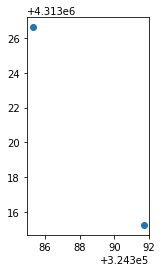

In [233]:
clean_list[4].plot()

In [243]:
for i in range(len(geodfs)):
    print('original:', geodfs[i].shape)
    print('post:', clean_list[i].shape)

original: (167, 30)
post: (273, 18)
original: (257, 30)
post: (579, 18)
original: (72, 30)
post: (78, 18)
original: (201, 30)
post: (243, 18)
original: (210, 30)
post: (248, 18)
original: (208, 30)
post: (316, 18)
original: (414, 30)
post: (522, 18)
original: (126, 30)
post: (169, 18)
original: (179, 30)
post: (215, 18)
original: (176, 30)
post: (242, 18)


---
## Assemble cleaned dataframes into list and export shapefiles

In [261]:
# Check CRS match
[clean_list[i].crs == clean_list[i+1].crs for i in np.arange(len(clean_list)-1)]

[True, True, True, True, True, True, True, True, True]

In [290]:
for i in clean_list:
    outpath = os.path.join(out_dir, 'Kueppers_EastRiver_Stem_Geolocations_WGS84UTM13N', i['Site'][0]+'_Stem_Geolocations_WGS84UTM13N.shp')
    i.to_file(outpath)

In [245]:
for i in clean_list:
    outpath = os.path.join(source_dir, 'TreeCoords', i['Site'][0]+'_Stem_Geolocations_WGS84UTM13N.csv')
    i.to_csv(outpath)

In [291]:
for i in os.listdir(os.path.join(out_dir, 'Kueppers_EastRiver_Stem_Geolocations_WGS84UTM13N')):
    if '.shp' in i:
        gdf = gpd.read_file(os.path.join(out_dir, 'Kueppers_EastRiver_Stem_Geolocations_WGS84UTM13N', i))
        outpath = os.path.join(source_dir, 'TreeCoords', i[:-4]+'.csv')
        gdf.to_csv(outpath)